In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import copy

%matplotlib inline

In [2]:
train = MNIST('../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

test = MNIST('../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        out = self.softmax(h)
        return out

In [6]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# for model_parm in model.parameters():
#     print(model_parm)
# print(model_parm.grad)

In [7]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
for epoch in range(5):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = criterion(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.214660	Accuracy: 0.9006
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.181705	Accuracy: 0.9102
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.169854	Accuracy: 0.9138
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.216284	Accuracy: 0.9097
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.312692	Accuracy: 0.9126


(0.33513996, 0.25829428)

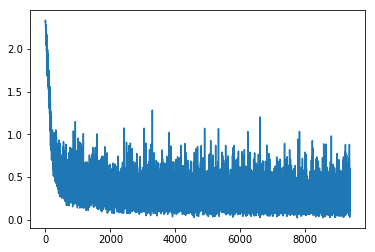

In [14]:
plt.plot(losses)
np.mean(losses), np.std(losses)

In [15]:
for model_parm in model.parameters():
        model_parm.requires_grad=False

In [16]:
evaluate_x = test.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets


output = model(evaluate_x)
pred = output.max(dim=1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])

print('Accuracy:', accuracy)

Accuracy: 0.9126


In [17]:
a = 1

In [30]:
print(-a)
print(losses[-a])
a+=1

-13
tensor(0.8817)


### Using  error to predict using another network

In [31]:
train_x = train_loader.dataset.data.type_as(torch.FloatTensor())
train_y = train_loader.dataset.targets

# with torch.no_grad():
x = train_x.view((-1, 784))
h = model.fc1(x)
h = F.relu(h)        
prev_final = model.fc2(h)
# out = model.softmax(h)

# with torch.no_grad():
x = evaluate_x.view((-1, 784))
h = model.fc1(x)
h = F.relu(h)        
prev_test_final = model.fc2(h)

In [32]:
class CustomMNIST(torch.utils.data.Dataset):

    def __init__(self, inputs, targets, prev_final):
        self.inputs = inputs
        self.targets = targets
        self.prev_final = prev_final

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.inputs[idx], self.targets[idx], self.prev_final[idx]

In [33]:
error0MNIST = CustomMNIST(train_x, train_y, prev_final.data)
dataloader_args = dict(shuffle=True, batch_size=32)
train1_loader = dataloader.DataLoader(error0MNIST, **dataloader_args)

In [34]:
class ModelE(nn.Module):
    def __init__(self):
        super(ModelE, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.fc2.weight.data *= 0.
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x, prev_final):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        if prev_final is not None:
            h = h + prev_final
        out = self.softmax(h)
        return out

In [41]:
model1 = ModelE()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()

In [42]:
losses1 = []
for epoch in range(5):
    data_count = 0
    max_iter = 0
    for batch_idx, (data, target, prev_final) in enumerate(train1_loader):

        y_pred = model1(data, prev_final) 
        loss = criterion(y_pred, target)
        losses1.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer1.step()
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model1(evaluate_x, prev_test_final)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}, M : {} --->'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,
                max_iter,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 44.721249	Accuracy: 0.9126, M : 0 --->
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 50.146519	Accuracy: 0.9128, M : 0 --->
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 128.316803	Accuracy: 0.9135, M : 0 --->
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 11.498766	Accuracy: 0.9139, M : 0 --->
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 57.168373	Accuracy: 0.914, M : 0 --->


(41.75803, 35.228893)

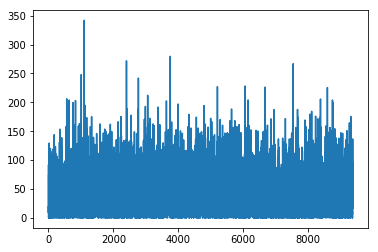

In [43]:
plt.plot(losses1)
np.mean(losses1), np.std(losses1)

In [44]:
output = model1(evaluate_x, prev_test_final)
pred = output.max(1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])
accuracy

0.914

### Visualization

0


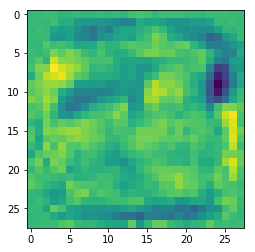

1


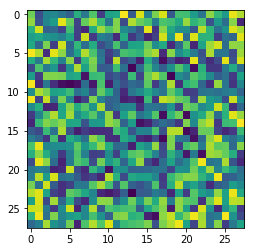

2


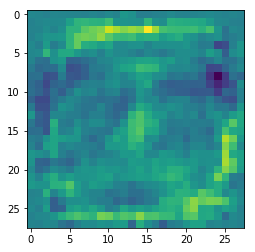

3


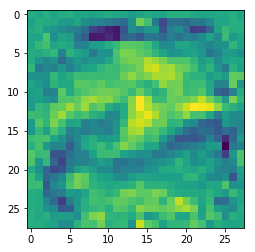

4


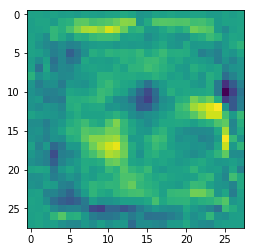

5


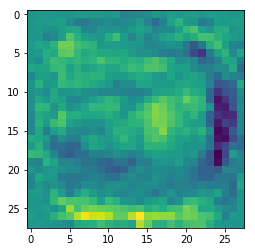

6


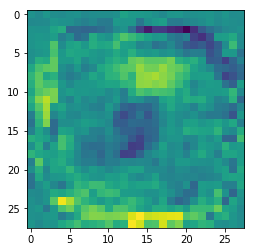

7


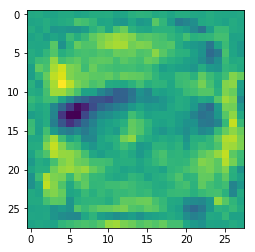

8


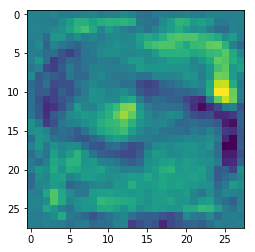

9


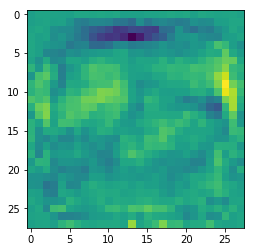

In [45]:
for i in range(10):
    img = model.fc1.weight.data[i].numpy().reshape(28,28)
    plt.imshow(img)
    print(i)
    plt.show()

0


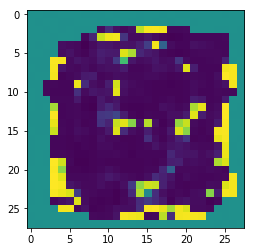

1


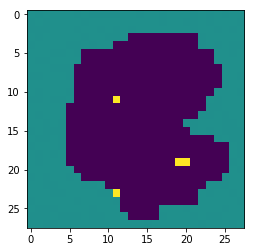

2


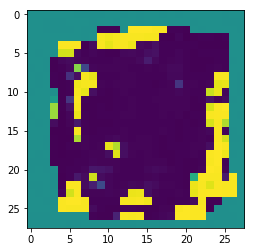

3


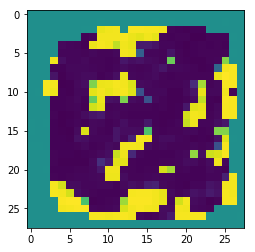

4


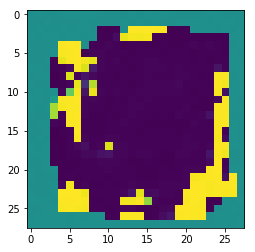

5


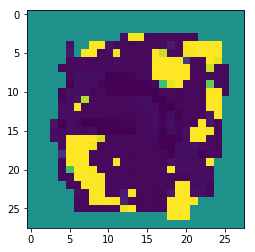

6


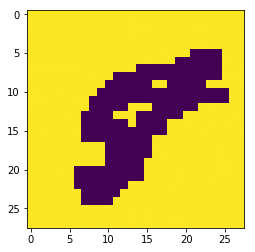

7


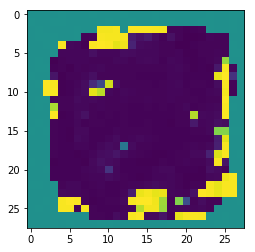

8


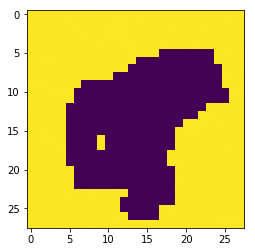

9


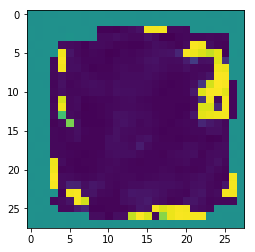

In [46]:
for i in range(10):
    img = model1.fc1.weight.data[i].numpy().reshape(28,28)
    plt.imshow(img)
    print(i)
    plt.show()